# Streaming Gaussian Mixture Model

## Update features when a new observation arrives

TODO

## Update the classifier

### General idea

Let $X = \{ x_1, \dotsc, x_N \}$ a collection of $N$ points. Now, lets suppose that the features of $x_j$ are updated, and lets call $x_j^{\star}$ the updated point. Lastly, lets define $X_{-j} = \{ x_1, \dotsc, x_{j-1}, x_{j+1}, \dotsc, x_N \}$.

The posterior before $x_j$ moves, and using $P(\Theta)$ as the prior is

$$P(\Theta \mid X) \propto P(X \mid \Theta)P(\Theta)$$,

where $P(X \mid \Theta) = \prod_i^N P(x_i \mid \Theta)$.

Now, after $x_j$ moves to $x_j^{\star}$, the posterior is

\begin{align*}
P(\Theta \mid X_{-j}, x_j^{\star}) &\propto P(X_{-j}, x_j^{\star} \mid \Theta)P(\Theta) \\
&\propto P(X_{-j} \mid \Theta)P(x_j^{\star} \mid \Theta)P(\Theta) \\
&\propto \frac{P(X \mid \Theta)}{P(x_j \mid \Theta)}P(x_j^{\star} \mid \Theta)P(\Theta) \\
&\propto \frac{P(x_j^{\star} \mid \Theta)}{P(x_j \mid \Theta)}P(X \mid \Theta)P(\Theta) \\
&\propto \frac{P(x_j^{\star} \mid \Theta)}{P(x_j \mid \Theta)}P(\Theta \mid X)
\end{align*}

### Mixture of GMM update

## Synthetic data generation

In the cell below we are going to generate synthetic data from multiple GMMs (one GMM per class).

In [59]:
import pandas as pd
import numpy as np
from scipy.stats import invwishart
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(rc={"figure.figsize": (6, 6)})

CLASS_COLORS = ['#66c2a5',
                '#fc8d62',
                '#8da0cb',
                '#e78ac3',
                '#a6d854',
                '#ffd92f',
                '#e5c494',
                '#b3b3b3']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
class GMMDataGenerator:
     
    def __init__(self, m, k, d, mu_interval=(-10, 10), mu_var=(-2, 2),
                 cov_var=(-1, 1), gamma_0=3.0, alpha_0=3.0):
        """
        Args:
            m (int): number of classes.
            k (int): number of components per class.
            d (int): dimension of data.
        """
        self.m = m
        self.k = k
        self.d = d
        self._mu_0 = np.zeros(d)
        self.gamma_0 = gamma_0
        self.alpha_0 = alpha_0
        self.mu_interval = mu_interval
        self.mu_var = mu_var
        self.cov_var = cov_var
        self.mu = np.zeros((m, k, d))
        self.cov = np.zeros((m, k, d, d))
        self._random_mean_and_cov()
        self.weights = np.random.dirichlet(self.gamma_0 * np.ones(k), size=m)
        
    def generate(self, n=2000):
        self.X = np.zeros((n, self.d))
        self.Z = np.zeros(n)
        
        # generate the class distributions
        self.pi = np.random.dirichlet(self.alpha_0 * np.ones(self.m))
        for i in range(n):
            # generate random class of this observation
            z_i = np.argmax(np.random.multinomial(1, self.pi))
            self.Z[i] = z_i
            
            # get a random component of this class
            w_im = np.argmax(np.random.multinomial(1, self.weights[z_i]))
            
            # generate the features
            self.X[i, :] = np.random.multivariate_normal(self.mu[z_i, w_im], 
                                                         self.cov[z_i, w_im])
    
    def get_obs(self):
        return self.X
    
    def get_labels(self):
        return self.Z.astype(int)
    
    def get_mu(self):
        return self.mu
    
    def get_cov(self):
        return self.cov
    
    def plot_2dproj(self, feat0=0, feat1=1, xlabel='', ylabel='', title=''):
        if not xlabel:
            xlabel = 'feature {}'.format(feat0)
        if not ylabel:
            ylabel = 'feature {}'.format(feat1)
        for m in range(self.m):
            l_class = np.where(self.Z == m)[0]
            plt.scatter(self.X[l_class, feat0], self.X[l_class, feat1], 
                        facecolor=CLASS_COLORS[m], alpha=0.5,
                        edgecolor='black', linewidth=0.15)
            plt.scatter(self.mu[m, :, feat0], self.mu[m, :, feat1],
                        facecolor=CLASS_COLORS[m], s=40)
        plt.title(title)
        #plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    def _random_mean_and_cov(self):
        a, b = self.mu_interval
        std_min, std_max = self.cov_var
        for i in range(self.m):
            mu_center = (b - a) * np.random.random() + a
            mu_max = mu_center + self.mu_var[1]
            mu_min = mu_center + self.mu_var[0]
            for j in range(self.k):
                self.cov[i, j, :] = invwishart.rvs(2 * self.d, np.eye(self.d))
                self.mu[i, j, :] = np.random.multivariate_normal(
                    self._mu_0 + mu_center, self.cov[i, j, :])

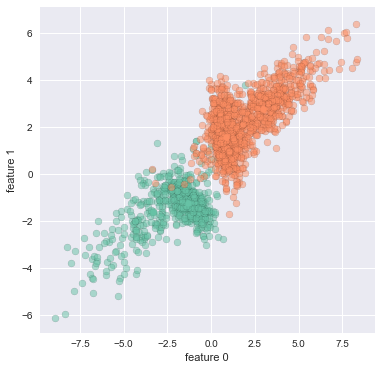

In [9]:
# Number of Gaussian Mixtures (classes).
M = 2

# Number of components per class.
K = 2

# Dimension of data.
D = 2

np.random.seed(2731774)

synthetic_gmm = GMMDataGenerator(m=M, k=K, d=D)
synthetic_gmm.generate(n=2000)
synthetic_gmm.plot_2dproj()

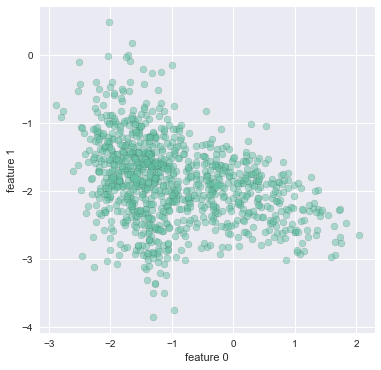

In [16]:
synthetic_gmm = GMMDataGenerator(m=1, k=K, d=D)
synthetic_gmm.generate(n=1000)
synthetic_gmm.plot_2dproj()

In [57]:
def plot_gmm(X, mu, W):
    assert mu.shape[0] == W.shape[0]
    dims = mu.shape[0]
    plt.scatter(X[:, 0], X[:, 1], 
                alpha=0.5,
                edgecolor='black', linewidth=0.15)
    min_x, min_y = np.amin(X, axis=0)
    max_x, max_y = np.amax(X, axis=0)
    x, y = np.mgrid[min_x:max_x:0.1, min_y:max_y:0.1]
    z = np.zeros(x.shape + (2,))
    z[:, :, 0] = x;
    z[:, :, 1] = y
    for i in range(mu.shape[0]):
        f_z = scipy.stats.multivariate_normal.pdf(z, mu[i, :], W[i, :])
        plt.contour(x, y, f_z, antialiased=True)
    plt.show()

[[[-1.5998845  -1.81833113]
  [-0.25856307 -1.92382937]]]


In [18]:
X = synthetic_gmm.get_obs()
C = synthetic_gmm.get_labels()
observed_mu = np.zeros((M, D))
for m in range(1):
    indexs = np.where(C == m)
    observed_mu[m] = X[indexs, :].mean(axis=1)
    print(observed_mu[m])

[-0.96244672 -1.87496733]


In [42]:
print(X[0, :].shape)

(2,)


In [19]:
print(np.squeeze(X[np.where(C == 0), :]).shape)

(1000, 2)


In [20]:
from mgmm_pymc.models import GaussianMixtureModel

GAMMA_0 = 5. * np.ones(K)
MU_0 = np.zeros(D)
NU_0 = 3.0

gmms = [GaussianMixtureModel(K=K, 
                             observed=np.squeeze(X[np.where(C == m), :]),
                             gamma_0=GAMMA_0,
                             mu_0=MU_0,
                             nu_0=NU_0) 
        for m in range(M)]

KeyboardInterrupt: 

In [23]:
%%time
mu_means = np.zeros((M, K, D))
lamb_means = np.zeros((M, K, D, D))
rho_means = np.zeros((M, K))

traces = []

for m in range(M):
    trace = gmms[m].train(samples=1e4, burn_in=2.5e3)
    traces.append(trace)
    mu_means[m, :] = gmms[m].mu_means
    lamb_means[m, :] = gmms[m].lambda_means
    rho_means[m, :] = gmms[m].rho_means
print(mu_means)

NameError: name 'gmms' is not defined

In [ ]:
pm.plots.traceplot(traces[0], ['rho']);

In [21]:
from vbmm.varmix import run

In [61]:
%%time
mu, W, vk = run(np.squeeze(X[np.where(C == 0), :]), 2)
W = np.asarray(W)

iteration 0
elbo: -1306021.00487
iteration 1
elbo: -1306023.67086
iteration 2
elbo: -1306028.03469
iteration 3
elbo: -1306036.3704
iteration 4
elbo: -1306053.49619
iteration 5
elbo: -1306086.47625
iteration 6
elbo: -1306130.79026
iteration 7
elbo: -1306139.81501
iteration 8
elbo: -1306130.31878
iteration 9
elbo: -1306489.2263
CPU times: user 490 ms, sys: 317 ms, total: 807 ms
Wall time: 414 ms


In [74]:
print(np.linalg.inv(W))

[[[ 554.37367738 -140.21315438]
  [-140.21315438  109.20227238]]

 [[ 157.3695912   -44.44339513]
  [ -44.44339513  248.6839146 ]]]


(2, 2, 2)


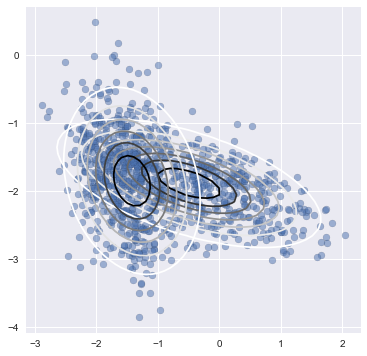

[[-0.49254159 -1.89385552]
 [-1.42007212 -1.85657274]]
[[[-1.5998845  -1.81833113]
  [-0.25856307 -1.92382937]]]


In [75]:
print(W.shape)
plot_gmm(X, mu, np.linalg.inv(vk*W))
print(mu)
print(synthetic_gmm.get_mu())

In [76]:
from vb_mgmm.var_bayes_gmm import VariationalBayesGMM

In [77]:
# We want to fail fast
np.seterr(all='raise')

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [87]:
%%time
vbGmm = VariationalBayesGMM(K, D)
vbGmm.fit(np.squeeze(X[np.where(C == 0), :]), max_iter=10)

Iteration: 0
ELBO: 3588.5617836819247
Variational mu: [[-0.92703409 -1.95287812]
 [-0.95923595 -1.87544558]]
ELBO IS DECREASING!!!!
Iteration: 1
ELBO: 3584.612258206051
Variational mu: [[-0.94967271 -1.96885313]
 [-0.94819134 -1.83525975]]
ELBO IS DECREASING!!!!
Iteration: 2
ELBO: 3584.333435323829
Variational mu: [[-0.96569172 -1.94930594]
 [-0.9536293  -1.81154772]]
Iteration: 3
ELBO: 3586.8052149259
Variational mu: [[-0.96978284 -1.92042103]
 [-0.96531645 -1.80983999]]
Iteration: 4
ELBO: 3589.318615468859
Variational mu: [[-0.96421187 -1.89684473]
 [-0.97721665 -1.8214216 ]]
Iteration: 5
ELBO: 3590.739150402327
Variational mu: [[-0.95419188 -1.87874632]
 [-0.98833034 -1.83746299]]
Iteration: 6
ELBO: 3590.959706087204
Variational mu: [[-0.94321781 -1.86386725]
 [-0.99846812 -1.85391452]]
ELBO IS DECREASING!!!!
Iteration: 7
ELBO: 3590.2070891231783
Variational mu: [[-0.93297143 -1.8503965 ]
 [-1.00765178 -1.86938735]]
ELBO IS DECREASING!!!!
Iteration: 8
ELBO: 3588.6441464475843
Variat

In [88]:
print(vbGmm.m_k)
print(synthetic_gmm.get_mu())

[[-0.91612393 -1.81994791]
 [-1.02573923 -1.89750041]]
[[[-1.5998845  -1.81833113]
  [-0.25856307 -1.92382937]]]


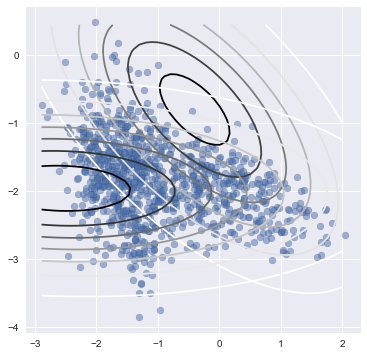

In [84]:
plot_gmm(X, vbGmm.m_k, np.linalg.inv(vbGmm.nu_k*vbGmm.W_k))